# Практическая работа №4

# Выполнил студент группы ББМО-01-23 Курдюков А.А.

## Шаги выполнения

### Шаг 1. Загрузка обученной модели и данных MNIST

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Загрузка тестовых данных MNIST
(_, _), (test_images, test_labels) = mnist.load_data()

# Нормализация данных
test_images = test_images / 255.0

# Преобразование меток в формат one-hot
test_labels = to_categorical(test_labels, num_classes=10)

# Загрузка обученной модели
model = tf.keras.models.load_model('/content/drive/MyDrive/AZSII/Pract_4/mnist_model.h5')

# Проверка точности модели на обычных данных
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9715 - loss: 0.0998
Test accuracy on clean images: 0.9754999876022339


###Шаг 2: Реализация атаки Carlini Wagner Attack

In [2]:
!pip install foolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 30.2 MB/s eta 0:00:00


tf.Tensor(7, shape=(), dtype=int64)


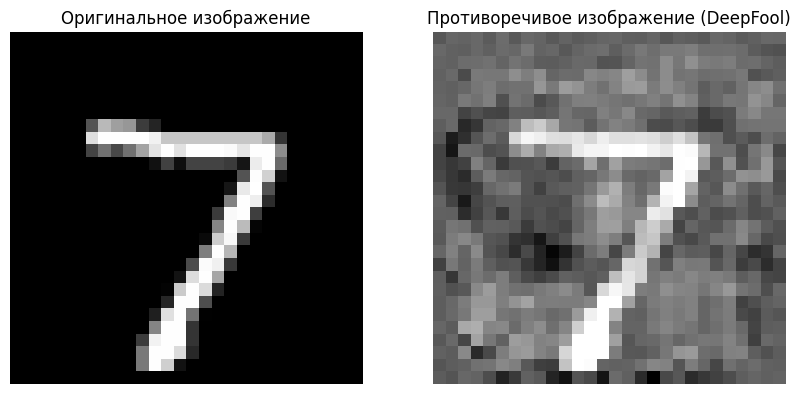

In [18]:
import torch
import torch.nn as nn
import foolbox as fb
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Инициализация Foolbox модели
fmodel = fb.TensorFlowModel(model, bounds=(-1, 1))

# Выбор изображения для атаки (например, первое изображение из тестового набора)
image = tf.convert_to_tensor(test_images[0], dtype=tf.float32)[None, ...]  # Добавляем размерность для батча
label = np.argmax(test_labels[0])  # Получаем индекс класса
label = tf.convert_to_tensor(label, dtype=tf.int64)  # Преобразуем в тензор

# Выполнение атаки
attack = fb.attacks.L2DeepFoolAttack(steps=10)
print(label)
advs, _, success = attack(fmodel, image, label[None], epsilons=0.01)  # Оборачиваем метку в тензор с размерностью (1,)

# Вывод результатов
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(image[0].numpy(), cmap="gray")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Противоречивое изображение (DeepFool)")
plt.imshow(advs[0].numpy(), cmap="gray")  # Предполагается, что advs имеет правильную форму
plt.axis('off')

plt.show()

###Шаг 3: Оценка модели на противоречивых примерах

In [22]:
# Установите количество обрабатываемых изображений

adversarial_images = []

# Обработка изображений
for i in range(len(test_images)):
    image = tf.convert_to_tensor(test_images[i], dtype=tf.float32)[None, ...]  # Форма (1, height, width, channels)
    label = np.argmax(test_labels[i])  # Получаем индекс класса
    label = tf.convert_to_tensor(label, dtype=tf.int64)
    advs, _, success = attack(fmodel, image, label[None], epsilons=0.01)
    adversarial_images.append(advs)

# Конвертация списка в массив с правильной формой
adversarial_images = tf.concat(adversarial_images, axis=0)  # Объединение по нулевой оси

# Убедитесь, что test_labels имеют соответствующее количество меток
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels)
print(f'Accuracy on adversarial examples (DeepFool): {adversarial_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 128.9736
Accuracy on adversarial examples (DeepFool): 0.0


#Вывод:
Точность модели на атакованных примерах значительно снизилась, и является около 0% (особенно если сравнивать с точностью на исходных данных) в зависимости от силы и шагов атаки.

Такое падение точности говорит о том, что модель не справляется с задачей распознавания в условиях небольших, но целенаправленных искажений. Это подчеркивает важность разработки более устойчивых моделей и применения методов защиты от атак, чтобы улучшить надежность в реальных приложениях.